This notebook is currently being worked on by Arsalan. Please avoid editing to avoid conflict.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

## Data Loading and Preprocessing
Reusable function for the different models.

In [ ]:
def load_and_preprocess_mnist():
  """
  Load and preprocess the MNIST dataset.

  This function loads the MNIST dataset, shuffles the training data,
  scales the images to the [0, 1] range, ensures that images have the shape (28, 28, 1),
  and converts class vectors to binary class matrices.

  Returns:
  Tuple of two tuples:
      - First tuple: (x_train, y_train) - Training data and labels
      - Second tuple: (x_test, y_test) - Testing data and labels
  """

  num_classes = 10
  input_shape = (28, 28, 1)

  # Load the data
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  # Shuffle the training data
  indices = np.arange(x_train.shape[0])
  np.random.shuffle(indices)
  x_train = x_train[indices]
  y_train = y_train[indices]

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255
  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  # Convert class vectors to binary class matrices
  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

Load data

In [ ]:
(x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()

# The SISA Approach

Model from ChatGPT.

Prompt: "Provide a simple MNIST model in Keras that achieves high accuracy."

In [ ]:
def createModel():
  """
  Create a convolutional neural network model for image classification.

  This model was obtained from ChatGPT with prompt: Provide a simple MNIST
  model in Keras that achieves high accuracy.
  """
  model = models.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  return model

### Create ensemble functions:

Method 1: Without slices.

In [ ]:
def createEnsemble1(num_shards, model_fn, epochs=1, batch_size=64):
  """
  Create an ensemble of `num_shards` "shard models" that share the same
  architecture and are trained on `num_shards` disjoint shards of the original dataset.

  Parameters:
  - num_shards (int): The number of shard models in the ensemble.
  - model_fn (function): A function that returns an instance of the model architecture.
  - epochs (int): The number of epochs to train each shard model. Default is 1.
  - batch_size (int): The batch size used during training. Default is 64.

  Returns:
  - ensemble (list): A list containing the trained shard models forming the ensemble.
  """

  ensemble = []

  subset_size = len(x_train) // num_shards

  for i in range(num_shards):
    start_index = i * subset_size
    end_index = (i + 1) * subset_size if i < num_shards - 1 else len(x_train)

    x_subset = x_train[start_index:end_index]
    y_subset = y_train[start_index:end_index]

    model = model_fn()

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_subset, y_subset, epochs=epochs, batch_size=batch_size, verbose=0)

    ensemble.append(model)

  return ensemble

Method 2: With slices, and storing the weights after each slice is learned.

In [ ]:
def createEnsemble2(num_shards, num_slices, model_fn, epochs=1, batch_size=64):
  """
  Create an ensemble of `num_shards` "shard models" that share the same
  architecture and are trained on disjoint shards of the original dataset.
  Additionally, record the set of weights for each shard model after learning each slice.

  Parameters:
  - num_shards (int): The number of shard models in the ensemble.
  - num_slices (int): The number of slices for each shard model.
  - model_fn (function): A function that returns an instance of the model architecture.
  - epochs (int): The number of epochs to train each shard model on each slice. Default is 1.
  - batch_size (int): The batch size used during training. Default is 64.

  Returns:
  - ensemble (list): A list containing the trained shard models forming the ensemble.
  - shard_slice_weights (list): A 2D list (shape: (num_shards, num_slices)) storing the set of weights
        of each shard model after learning each slice.
  """

  # An array to store each shard model
  ensemble = []
  # An array of shape (num_shards, num_slices) to store the set of weights of
  # each shard model after learning a slice
  shard_slice_weights = []

  shard_size = len(x_train) // num_shards
  slice_size = shard_size // num_slices

  # Outer loop to iterate through the different shards (subsets) to create an
  # ensemble of "shard models" trained on disjoint shards of the dataset.
  for i in range(num_shards):
    # Array to store weights of the shard model after learning each slice
    slice_weights = []

    start_index = i * shard_size
    end_index = (i + 1) * shard_size if i < num_shards - 1 else len(x_train)

    x_subset = x_train[start_index:end_index]
    y_subset = y_train[start_index:end_index]

    model = model_fn()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Inner loop to iterate through the slices (sub-subsets)
    for j in range(num_slices):
      for epoch in range(epochs):
        slice_start = j * slice_size
        slice_end = (j + 1) * slice_size if j < num_slices - 1 else shard_size

        x_slice = x_subset[slice_start:slice_end]
        y_slice = y_subset[slice_start:slice_end]

        model.fit(x_slice, y_slice, epochs=1, batch_size=batch_size, verbose=0)

      slice_weights.append(model.get_weights())

    ensemble.append(model)
    shard_slice_weights.append(slice_weights)

  return ensemble, shard_slice_weights

### Testing Accuracy w/ Different Ensembling Methods

In [ ]:
def testEnsemble(ensemble, x_test, y_test):
  """
  Test the accuracies of an ensemble of models.
  One ensembling method is simply the majority vote, and another is a weighted
  majority vote.

  Parameters:
  - ensemble (list): A list of individual models to form the ensemble.
  - x_test (numpy.ndarray): Testing data.
  - y_test (numpy.ndarray): True labels for the testing data.

  Returns:
  - majority_ensemble_accuracy (float): Accuracy of the ensemble based on majority voting.
  - weighted_ensemble_accuracy (float): Accuracy of the ensemble based on weighted voting.
  - individual_accuracies (list): List of accuracies for each individual model in the ensemble.
  """

  x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

  # Initialize arrays for storing predictions and accuracies
  ensemble_predictions = np.zeros_like(y_test)
  weighted_predictions = np.zeros_like(y_test)
  individual_accuracies = [] # Accuracies for the individual models within the ensemble

  for model in ensemble:
    model_predictions = model.predict(x_test, verbose=0)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    individual_accuracies.append(test_acc)

    # Update the ensemble predictions
    ensemble_predictions += model_predictions # Regular predictions
    weighted_predictions += model_predictions * val_acc # Weighted predictions

  # Take the majority vote and weighted vote
  ensemble_predictions = np.argmax(ensemble_predictions, axis=1)
  weighted_predictions = np.argmax(weighted_predictions, axis=1)

  # Convert true labels to indices
  true_labels = np.argmax(y_test, axis=1)

  # Calculate accuracy of the ensemble
  majority_ensemble_accuracy = accuracy_score(true_labels, ensemble_predictions)
  weighted_ensemble_accuracy = accuracy_score(true_labels, weighted_predictions)

  return majority_ensemble_accuracy, weighted_ensemble_accuracy, individual_accuracies

### Unlearning Process
Assumes createEnsemble2 is used

In [ ]:
def unlearnData(num_remove, shard_num, slice_num, ensemble, shard_slice_weights, epochs=1, batch_size=64):
  """
  Unlearn a specified number of data points from a specific shard and slice in an ensemble of shard models.

  Parameters:
  - num_remove (int): Number of data points to be removed from the specified shard and slice.
  - shard_num (int): Index of the shard within the ensemble to unlearn from.
  - slice_num (int): Index of the slice within the shard to unlearn from.
  - ensemble (list): List of models representing the ensemble.
  - shard_slice_weights (list): Weight checkpoints of each slice in each shard.
  - epochs (int, optional): Number of training epochs when retraining. Default is 1.
  - batch_size (int, optional): Batch size for training. Default is 64.

  Returns:
  - duration (float): Duration of the unlearning process in seconds.
  - ensemble (list): Updated ensemble after unlearning.
  - shard_slice_weights (list): Updated weight checkpoints of each slice in each shard.
  """

  # Record the start time
  start_time = time.time()

  num_shards = len(ensemble)
  num_slices = len(shard_slice_weights[0])

  shard_size = len(x_train) // num_shards
  slice_size = shard_size // num_slices

  # Identify the relevant model and reset weights
  model = ensemble[shard_num]
  model.set_weights(shard_slice_weights[shard_num][slice_num])

  # Set indices for the relevant shard/subset of data
  start_index = shard_num * shard_size
  end_index = (shard_num + 1) * shard_size if shard_num < num_shards - 1 else len(x_train)

  # Identify the relevant shard/subset of data
  x_subset = x_train[start_index:end_index]
  y_subset = y_train[start_index:end_index]

  # Set indices for the relevant slice/sub-subset of data
  slice_start = slice_num * slice_size
  slice_end = (slice_num + 1) * slice_size if slice_num < num_slices - 1 else shard_size

  # Identify the relevant slice/sub-subset of data
  x_slice = x_subset[slice_start:slice_end]
  y_slice = y_subset[slice_start:slice_end]

  # Relearn the current shard without the num_remove points
  for epoch in range(epochs):
    model.fit(x_slice[num_remove:], y_slice[num_remove:], epochs=1, batch_size=batch_size, verbose=0)
  shard_slice_weights[shard_num][slice_num] = model.get_weights()

  # Relearn the subsequent slices, if any
  if slice_num + 1 < num_slices:
    for j in range(slice_num + 1, num_slices):
      for epoch in range(epochs):
        slice_start = j * slice_size
        slice_end = (j + 1) * slice_size if j < num_slices - 1 else shard_size

        x_slice = x_subset[slice_start:slice_end]
        y_slice = y_subset[slice_start:slice_end]

        model.fit(x_slice, y_slice, epochs=1, batch_size=batch_size, verbose=0)

      shard_slice_weights[shard_num][j] = model.get_weights()

  ensemble[shard_num] = model

  # Record the end time
  end_time = time.time()

  # Calculate the retraining time
  duration = end_time - start_time

  return duration, ensemble, shard_slice_weights

### Testing and Results

In [ ]:
ensemble, shard_slice_weights = createEnsemble2(2, 5, createModel)
majority_ensemble_accuracy, weighted_ensemble_accuracy, individual_accuracies = testEnsemble(ensemble, x_test, y_test)
print(f'Majority ensemble Accuracy: {majority_ensemble_accuracy}')
print(f'Weighted ensemble Accuracy: {weighted_ensemble_accuracy}')
print(f'Individual Accuracies: {[round(acc, 4) for acc in individual_accuracies]}')

Majority ensemble Accuracy: 0.9814
Weighted ensemble Accuracy: 0.9814
Individual Accuracies: [0.968, 0.9804]


In [ ]:
print(f'Creating ensemble using {100} shards and {5} slices...')
ensemble, shard_slice_weights = createEnsemble2(100, 5, createModel)
print('')

print(f'Accuracies before unlearning {100} points:')
majority_ensemble_accuracy, weighted_ensemble_accuracy, individual_accuracies = testEnsemble(ensemble, x_test, y_test)
print(f'Majority ensemble Accuracy: {majority_ensemble_accuracy}')
print(f'Weighted ensemble Accuracy: {weighted_ensemble_accuracy}')
print(f'Individual Accuracies: {[round(acc, 4) for acc in individual_accuracies]}')
print('')

print(f'Unlearning {100} points from shard {0}, slice {4}... (arbitrary shard and slice)')
duration, ensemble, shard_slice_weights = unlearnData(100, 0, 4, ensemble, shard_slice_weights)
print(f'Unlearning duration: {duration} s')
print('')

print(f'Accuracies after unlearning {100} points:')
majority_ensemble_accuracy, weighted_ensemble_accuracy, individual_accuracies = testEnsemble(ensemble, x_test, y_test)
print(f'Majority ensemble Accuracy: {majority_ensemble_accuracy}')
print(f'Weighted ensemble Accuracy: {weighted_ensemble_accuracy}')
print(f'Individual Accuracies: {[round(acc, 4) for acc in individual_accuracies]}')
print('-------------------------------------------')

Creating ensemble using 100 shards and 5 slices...

Accuracies before unlearning 100 points:
Majority ensemble Accuracy: 0.7634
Weighted ensemble Accuracy: 0.7604
Individual Accuracies: [0.4104, 0.4534, 0.4502, 0.3784, 0.3922, 0.4984, 0.3896, 0.6112, 0.5988, 0.5512, 0.4874, 0.5326, 0.252, 0.2826, 0.3698, 0.346, 0.4504, 0.4642, 0.4192, 0.4552, 0.608, 0.2932, 0.5304, 0.3886, 0.4608, 0.5212, 0.4952, 0.5326, 0.4962, 0.3206, 0.5286, 0.3028, 0.4698, 0.4638, 0.6126, 0.5016, 0.4826, 0.5808, 0.6382, 0.4756, 0.5162, 0.3906, 0.3998, 0.5296, 0.5352, 0.5356, 0.551, 0.5386, 0.421, 0.4194, 0.3868, 0.536, 0.5302, 0.445, 0.5038, 0.4206, 0.424, 0.4408, 0.3538, 0.4144, 0.5124, 0.525, 0.4186, 0.5514, 0.4246, 0.4652, 0.4474, 0.4882, 0.4538, 0.3504, 0.5612, 0.557, 0.4738, 0.3722, 0.505, 0.4024, 0.474, 0.4914, 0.4014, 0.4464, 0.456, 0.4434, 0.5662, 0.4228, 0.4396, 0.5176, 0.4514, 0.3308, 0.4046, 0.3624, 0.265, 0.5242, 0.3082, 0.4824, 0.4234, 0.5152, 0.5506, 0.4736, 0.5792, 0.4486]

Unlearning 100 points from

In [ ]:
print(f'Creating ensemble using {100} shards and {5} slices...')
ensemble, shard_slice_weights = createEnsemble2(100, 5, createModel)
duration, ensemble, shard_slice_weights = unlearnData(100, 0, 4, ensemble, shard_slice_weights)
print(f'Unlearning duration: {duration} s')

Creating ensemble using 100 shards and 5 slices...
Unlearning duration: 0.24663972854614258 s


In [ ]:
num_shards = [1, 2, 5, 10, 25, 50, 100]
majority_accs_initial = []
weighted_accs_initial = []
indiv_accs_initial = []
durations = []
majority_accs_unlearned = []
weighted_accs_unlearned = []
indiv_accs_unlearned = []

for n in num_shards:
  print(f'Creating ensemble using {n} shards and {5} slices...')
  ensemble, shard_slice_weights = createEnsemble2(n, 5, createModel)
  print('')

  print(f'Accuracies before unlearning {100} points:')
  majority_ensemble_accuracy, weighted_ensemble_accuracy, individual_accuracies = testEnsemble(ensemble, x_test, y_test)
  majority_accs_initial.append(majority_ensemble_accuracy)
  weighted_accs_initial.append(weighted_ensemble_accuracy)
  indiv_accs_initial.append(individual_accuracies)
  print(f'Majority ensemble Accuracy: {majority_ensemble_accuracy}')
  print(f'Weighted ensemble Accuracy: {weighted_ensemble_accuracy}')
  print(f'Individual Accuracies: {[round(acc, 4) for acc in individual_accuracies]}')
  print('')

  print(f'Unlearning {100} points from shard {0}, slice {4}... (arbitrary shard and slice)')
  duration, ensemble, shard_slice_weights = unlearnData(100, 0, 4, ensemble, shard_slice_weights)
  durations.append(duration)
  print(f'Unlearning duration: {duration} s')
  print('')

  print(f'Accuracies after unlearning {100} points:')
  majority_ensemble_accuracy, weighted_ensemble_accuracy, individual_accuracies = testEnsemble(ensemble, x_test, y_test)
  majority_accs_unlearned.append(majority_ensemble_accuracy)
  weighted_accs_unlearned.append(weighted_ensemble_accuracy)
  indiv_accs_unlearned.append(individual_accuracies)
  print(f'Majority ensemble Accuracy: {majority_ensemble_accuracy}')
  print(f'Weighted ensemble Accuracy: {weighted_ensemble_accuracy}')
  print(f'Individual Accuracies: {[round(acc, 4) for acc in individual_accuracies]}')
  print('-------------------------------------------')
  print('\n')

### Plotting Results

In [ ]:
num_shards = [1, 2, 5, 10, 25, 50, 100]
majority_accs_initial = [0.9852, 0.9798, 0.9674, 0.9386, 0.892, 0.8118, 0.7634]
weighted_accs_initial = [0.9852, 0.9798, 0.9674, 0.9386, 0.892, 0.8136, 0.7604]
durations = [0.8676183223724365, 0.6991350650787354, 0.3996865749359131, 0.14453744888305664, 0.09999442100524902, 0.08209109306335449, 0.3749871253967285]
majority_accs_unlearned = [0.9884, 0.9816, 0.9668, 0.9394, 0.8926, 0.8128, 0.7626]
weighted_accs_unlearned = [0.9884, 0.9816, 0.967, 0.9396, 0.8932, 0.8146, 0.761]

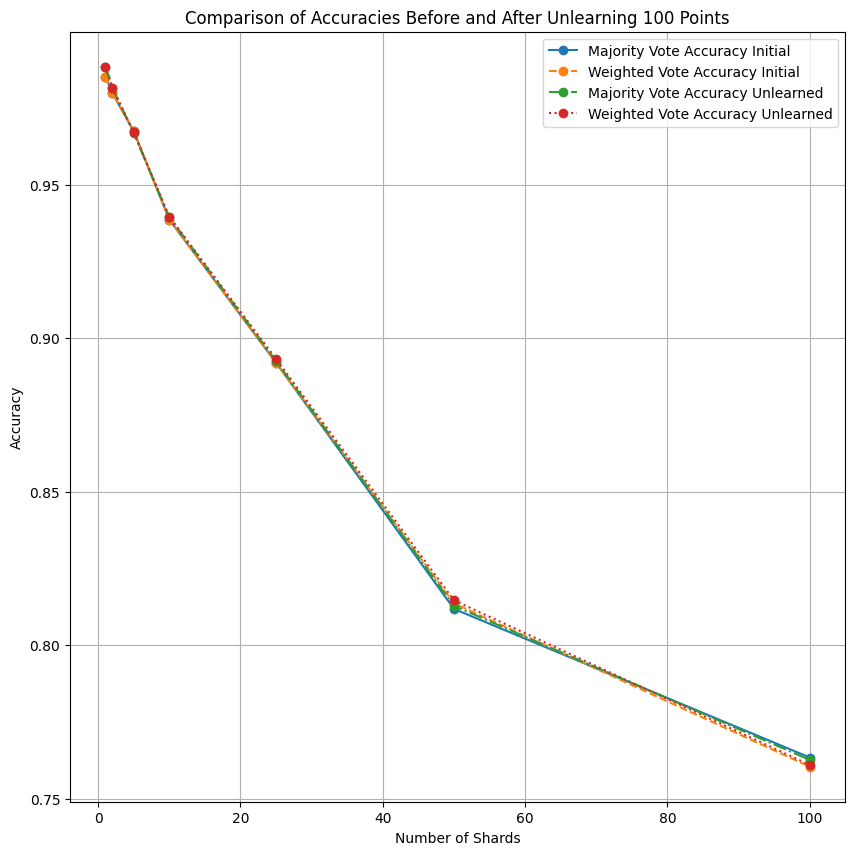

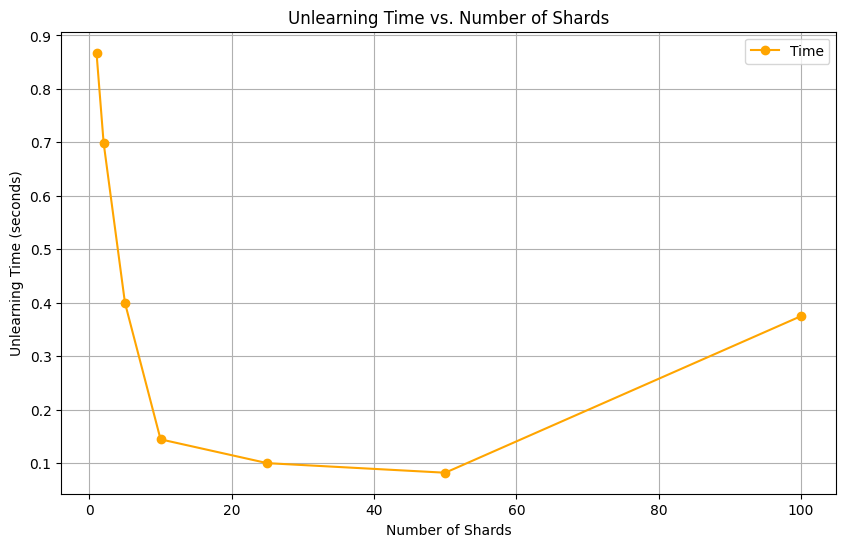

In [ ]:
# Plotting majority_accs_initial, weighted_accs_initial, majority_accs_unlearned, and weighted_accs_unlearned
plt.figure(figsize=(10, 10))
plt.plot(num_shards, majority_accs_initial, label='Majority Vote Accuracy Initial', marker='o', linestyle='-')
plt.plot(num_shards, weighted_accs_initial, label='Weighted Vote Accuracy Initial', marker='o', linestyle='--')
plt.plot(num_shards, majority_accs_unlearned, label='Majority Vote Accuracy Unlearned', marker='o', linestyle='-.')
plt.plot(num_shards, weighted_accs_unlearned, label='Weighted Vote Accuracy Unlearned', marker='o', linestyle=':')
plt.xlabel('Number of Shards')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies Before and After Unlearning 100 Points')
plt.legend()
plt.grid(True)
plt.show()

# Plotting durations vs. num_shards
plt.figure(figsize=(10, 6))
plt.plot(num_shards, durations, label='Time', marker='o', color='orange')
plt.xlabel('Number of Shards')
plt.ylabel('Unlearning Time (seconds)')
plt.title('Unlearning Time vs. Number of Shards')
plt.legend()
plt.grid(True)
plt.show()